In [ ]:
# 1. Install the required packages
# On Windows, you just need to execute this cell for once.
try:
    import google.colab
    # IN_COLAB = True
except ImportError:
    # IN_COLAB = False
    %pip install -q git+https://github.com/huggingface/transformers
    %pip install -q git+https://github.com/huggingface/accelerate

%pip install -q git+https://github.com/huggingface/diffusers
%pip install -q gradio ftfy tensorboard peft
%pip install -q bitsandbytes
#%pip install -U git+https://github.com/TimDettmers/bitsandbytes.git
%pip install -q xformers --index-url https://download.pytorch.org/whl/cu124
#%pip install -U git+https://github.com/facebookresearch/xformers.git@main
print("Package installation finished.")

In [1]:
# 2. Create folders and download training scripts
import os, shutil

dataset_dir = "./dataset"
output_dir = "./output"
logging_dir = "./logs"
class_dir = "./class"

token_name = "sks"
pipeline = None

def reset_data():
  # Create the directories if they don't exist
  os.makedirs(dataset_dir, exist_ok=True)
  # Delete the 'output' folder and its contents
  shutil.rmtree(output_dir, ignore_errors=True)
  os.makedirs(output_dir, exist_ok=True)
  # Delete the 'log' folder and its contents
  shutil.rmtree(logging_dir, ignore_errors=True)
  os.makedirs(logging_dir, exist_ok=True)
  # Delete the 'class' folder and its contents
  # shutil.rmtree(class_dir, ignore_errors=True)
  os.makedirs(class_dir, exist_ok=True)
  # Delete the 'dataset' folder and its contents
  # shutil.rmtree(dataset_dir, ignore_errors=True)
  # os.makedirs(dataset_dir, exist_ok=True)

try:
    import google.colab
    # fetch train_dreambooth.py if it doesn't exist
    if not os.path.exists("train_dreambooth_lora.py"):
        !wget https://raw.githubusercontent.com/jomo0825/MrFuGenerativeAI/main/LoRA/train_dreambooth_lora.py
    else:
        print("train_dreambooth_lora.py already exists, skipping download.")

    # fetch convertosdv2.py if it doesn't exist
    if not os.path.exists("convert_diffusers_to_original_stable_diffusion.py"):
        !wget https://raw.githubusercontent.com/jomo0825/MrFuGenerativeAI/main/utils/convert_diffusers_to_original_stable_diffusion.py
    else:
        print("convert_diffusers_to_original_stable_diffusion.py already exists, skipping download.")
except ImportError:
    # fetch train_dreambooth.py if it doesn't exist
    if not os.path.exists("train_dreambooth_lora.py"):
        !curl -O https://raw.githubusercontent.com/jomo0825/MrFuGenerativeAI/main/LoRA/train_dreambooth_lora.py
    else:
        print("train_dreambooth_lora.py already exists, skipping download.")

    # fetch convertosdv2.py if it doesn't exist
    if not os.path.exists("convert_diffusers_to_original_stable_diffusion.py"):
        !curl -O https://raw.githubusercontent.com/jomo0825/MrFuGenerativeAI/main/utils/convert_diffusers_to_original_stable_diffusion.py
    else:
        print("convert_diffusers_to_original_stable_diffusion.py already exists, skipping download.")

ipynb_checkpoints = os.path.join( dataset_dir, ".ipynb_checkpoints")
shutil.rmtree(".gradio", ignore_errors=True)
shutil.rmtree(".config", ignore_errors=True)
shutil.rmtree(ipynb_checkpoints, ignore_errors=True)

reset_data()

train_dreambooth_lora.py already exists, skipping download.
convert_diffusers_to_original_stable_diffusion.py already exists, skipping download.


In [2]:
# 3. Create a WebUI for LoRA Dreambooth training
# It will download the SD v1.5 for the 1st time training
# A very good reference:
# https://www.reddit.com/r/StableDiffusion/comments/ybxv7h/good_dreambooth_formula/

import gradio as gr
import sys
import threading
from train_dreambooth_lora import main as train_dreambooth_lora
from train_dreambooth_lora import parse_args
import time, os, logging, shutil
from os import path
import subprocess
import shlex
import queue
from PIL import Image

def parse_lr_schedule(lr_schedule_str):
    schedule = []
    segments = lr_schedule_str.split(',')
    for segment in segments:
        if ':' in segment:
            lr, steps = segment.split(':')
            schedule.append((float(lr), int(steps)))
        else:
            schedule.append((float(segment), None))  # Final constant learning rate
    return schedule

def get_learning_rate_at_step(lr_schedule, step):
    current_step = 0
    for lr, segment_steps in lr_schedule:
        if segment_steps is None or step < current_step + segment_steps:
            return lr
        current_step += segment_steps
    return lr_schedule[-1][0]  # Return the last LR if beyond defined steps

# Callback to update the preview image in the UI
def preview_callback(image, step):
    global current_preview, current_status, max_train_steps, current_step
    current_step = step
    current_preview = image
    print(f"{step}/{max_train_steps}")

def stop_training():
    global stop_flag
    stop_flag.set()
    return gr.update(value="Training will be stopped...Waiting for the final preview...")

def run_training(prompt, instance_prompt, class_prompt, num_training_steps,
                learning_rate, batch_size, preview_save_steps, preview_seed, rank):
    global current_preview, current_status, max_train_steps, token_name
    global current_step, finish_event, stop_flag, pipeline
    current_preview = None  # Reset the preview
    current_status = "Training started..."  # Initial status
    token_name = instance_prompt
    pipeline = None

    # Define LoRA DreamBooth training parameters as a list of command-line arguments.
    command = [
        "--pretrained_model_name_or_path", "stable-diffusion-v1-5/stable-diffusion-v1-5",  # or your chosen model
        "--instance_data_dir", dataset_dir,  # folder with your subject images
        "--instance_prompt", instance_prompt,  # prompt identifier for your subject
        "--output_dir", output_dir,          # where to save your LoRA model
        "--train_batch_size", str(batch_size),
        "--resolution", "512",
        "--lr_scheduler", "cosine",
        "--learning_rate", str(learning_rate),
        "--lr_warmup_steps", "0",
        "--gradient_accumulation_steps", "1",
        "--num_validation_images", "1",
        "--validation_prompt", prompt,
        "--validation_steps", str(preview_save_steps),
        "--max_train_steps", str(num_training_steps),
        "--mixed_precision", "no",
        "--use_8bit_adam",
        "--gradient_checkpointing",
        "--enable_xformers_memory_efficient_attention",
        "--logging_dir", logging_dir,
        "--seed", str(preview_seed),
        "--checkpointing_steps", str(num_training_steps+1),
        "--rank", str(rank),  # LoRA rank parameter
        "--output_kohya_format",
        
        # "--class_data_dir", class_dir,        # folder with class images (for prior preservation)
        # "--class_prompt", class_prompt,        # prompt for class images
        # "--with_prior_preservation",           # enable prior preservation if you have class images
        # "--num_class_images", "10",           # adjust based on your available class images
    ]

    args = parse_args(command)
    max_train_steps = args.max_train_steps

    # Print the command for debugging
    print("Command:", " ".join(command))

    # Disable logging
    logging.getLogger("accelerate").disabled = True

    def worker(finish_event, stop_flag):
        try:
            train_dreambooth_lora(args, {"_callback": preview_callback, "stop_flag": stop_flag})
        except Exception as e:
            print(f"Training error: {e}")
        finally:
            finish_event.set()

    finish_event = threading.Event()
    stop_flag = threading.Event()
    finish_event.clear()
    stop_flag.clear()

    train_thread = threading.Thread(target=worker, args=(finish_event, stop_flag))
    train_thread.start()
    yield gr.update(value=None), gr.update(value=f"Training started.")

    while not finish_event.is_set():
        if current_preview is not None:
            yield gr.update(value=current_preview), gr.update(value=f"Preview at {current_step} step.")
            current_preview = None
        time.sleep(1)

    train_thread.join()

    # Update status when training completes
    current_status = "Saving LoRA model..."
    yield gr.update(value=current_preview), gr.update(value=current_status)
    pipeline = None

    # Save the model in a format compatible with original Stable Diffusion
    try:
        # subprocess.run(["python", "convert_lora_to_safetensors.py", "--model_path", output_dir, "--checkpoint_path", "lora_model.safetensors"], check=True)
        current_status = "LoRA model saved successfully!"
    except Exception as e:
        current_status = f"Error saving model: {e}"

    yield gr.update(value=current_preview), gr.update(value=current_status)

# Define a function to move the selected file
def copy_file(target_directory, file_path):
    if file_path is not None:
        filename = os.path.basename(file_path)
        destination_path = os.path.join(target_directory, filename)
        # test if the destination_path already exists
        if not os.path.exists(destination_path):
            shutil.copy(file_path, destination_path)
            print(f"Copy {filename} to {target_directory}")
        else:
            print(f"{filename} already exists.")
    else:
        print("No file selected.")

def process_files(files):
    file_info = []
    
    # Make sure dataset directory exists
    os.makedirs(dataset_dir, exist_ok=True)

    for file in files:
        fileBasename = os.path.basename(file)
        destination_path = os.path.join(dataset_dir, fileBasename)
        if not os.path.exists(destination_path):
            file_info.append(f"File: {file.name}")
            copy_file(dataset_dir, file.name)
    return f"{len(file_info)} files uploaded."

def process_class_files(files):
    file_info = []
    
    # Make sure class directory exists
    os.makedirs(class_dir, exist_ok=True)

    for file in files:
        fileBasename = os.path.basename(file)
        destination_path = os.path.join(class_dir, fileBasename)
        if not os.path.exists(destination_path):
            file_info.append(f"File: {file.name}")
            copy_file(class_dir, file.name)
    return f"{len(file_info)} files uploaded."

def delete_dataset():
    shutil.rmtree(dataset_dir, ignore_errors=True)
    os.makedirs(dataset_dir, exist_ok=True)
    return "Dataset deleted."

def delete_class_images():
    shutil.rmtree(class_dir, ignore_errors=True)
    os.makedirs(class_dir, exist_ok=True)
    return "Class images deleted."

def reset_data():
    delete_dataset()
    delete_class_images()
    return "All data reset."

# Create directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(class_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

def ui():
    with gr.Blocks() as demo:
        gr.Markdown("# Stable Diffusion LoRA Dreambooth WebUI")
        gr.Markdown("Train Stable Diffusion model with LoRA for faster fine-tuning and lower memory usage.")
        with gr.Row():
            with gr.Column():
                with gr.Row():
                    file_input = gr.File(file_count="multiple", label="Upload Dataset",
                        height=200, file_types=["image"])
                with gr.Row():
                    submit_btn = gr.Button("Upload Dataset")
                    delete_data_btn = gr.Button("Delete Dataset")
                with gr.Row():
                    output = gr.Textbox(label="Results")
                submit_btn.click(fn=process_files, inputs=file_input, outputs=output)
                delete_data_btn.click(fn=delete_dataset, outputs=output)
            with gr.Column():
                with gr.Row():
                    class_file_input = gr.File(file_count="multiple", label="Upload Class Images",
                        height=200, file_types=["image"])
                with gr.Row():
                    class_submit_btn = gr.Button("Upload Class Images")
                    class_delete_data_btn = gr.Button("Delete Class Images")
                with gr.Row():
                    class_output = gr.Textbox(label="Results")
                class_submit_btn.click(fn=process_class_files, inputs=class_file_input, outputs=class_output)
                class_delete_data_btn.click(fn=delete_class_images, outputs=class_output)

        with gr.Row():
            with gr.Column(scale=1, min_width=300):
                instance_prompt = gr.Textbox(label="Instance Prompt (your subject)", 
                    placeholder="a photo of sks person", interactive=True)
                class_prompt = gr.Textbox(label="Class Prompt", 
                    placeholder="a photo of person", interactive=True)
                prompt = gr.Textbox(label="Preview Prompt", 
                    placeholder="a photo of sks person on the beach", interactive=True)
                num_training_steps = gr.Number(label="Number of Training Steps", value=1500, interactive=True)
                learning_rate = gr.Number(label="Learning Rate", value=0.0001, interactive=True)
                batch_size = gr.Number(label="Batch Size", value=1, interactive=True)
                preview_save_steps = gr.Number(label="Preview Steps", value=50, interactive=True)
                preview_seed = gr.Number(label="Preview Seed", value=1, interactive=True)
                rank = gr.Slider(label="LoRA Rank", minimum=1, maximum=128, value=32, step=1, 
                    info="Higher rank = more capacity but larger file size")
            with gr.Column(scale=1, min_width=300):
                output_image = gr.Image(label="Generated Image")
                generate_status = gr.Textbox(value="Status messages will appear here.", label="Status", interactive=False)
                generate_button = gr.Button("Start Training")
                cancel_button = gr.Button("Cancel Training")
                reset_button = gr.Button("Reset Data")

        generate_button.click(
            fn=run_training,
            inputs=[prompt, instance_prompt, class_prompt, num_training_steps,
                    learning_rate, batch_size, preview_save_steps, preview_seed, rank],
            outputs=[output_image, generate_status],
            show_progress=True,
            queue=True
        )

        cancel_button.click(
            fn=stop_training,
            outputs=[generate_status]
        )

        reset_button.click(
            fn=reset_data,
        )

    return demo

# Initialize global variables
current_preview = None
current_status = "Ready"
max_train_steps = 0
current_step = 0
token_name = ""
finish_event = None
stop_flag = None
pipeline = None

# Launch the UI
demo = ui()
demo.launch(debug=True)
# demo.launch()

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\anaconda3\envs\diffusion\lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
ModuleNotFoundError: No module named 'triton'


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


03/28/2025 03:14:13 - INFO - train_dreambooth_lora - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no



Command: --pretrained_model_name_or_path stable-diffusion-v1-5/stable-diffusion-v1-5 --instance_data_dir ./dataset --instance_prompt sks --output_dir ./output --train_batch_size 1 --resolution 512 --lr_scheduler cosine --learning_rate 0.0001 --lr_warmup_steps 0 --gradient_accumulation_steps 1 --num_validation_images 1 --validation_prompt sks --validation_steps 20 --max_train_steps 100 --mixed_precision no --use_8bit_adam --gradient_checkpointing --enable_xformers_memory_efficient_attention --logging_dir ./logs --seed 1 --checkpointing_steps 101 --rank 8 --output_kohya_format


You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type', 'thresholding', 'clip_sample_range', 'sample_max_value', 'prediction_type', 'rescale_betas_zero_snr', 'dynamic_thresholding_ratio', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Instantiating AutoencoderKL model under default dtype torch.float32.
{'shift_factor', 'use_post_quant_conv', 'scaling_factor', 'latents_std', 'latents_mean', 'mid_block_add_attention', 'use_quant_conv', 'force_upcast'} was not found in config. Values will be initialized to default values.
All model checkpoint weights were used when initializing AutoencoderKL.

All the weights of AutoencoderKL were initialized from the model checkpoint at stable-diffusion-v1-5/stable-diffusion-v1-5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use AutoencoderKL fo

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

DEBUG: 1 / 20
DEBUG: 2 / 20
DEBUG: 3 / 20
DEBUG: 4 / 20
DEBUG: 5 / 20
DEBUG: 6 / 20
DEBUG: 7 / 20
DEBUG: 8 / 20
DEBUG: 9 / 20
DEBUG: 10 / 20
DEBUG: 11 / 20
DEBUG: 12 / 20
DEBUG: 13 / 20
DEBUG: 14 / 20
DEBUG: 15 / 20
DEBUG: 16 / 20
DEBUG: 17 / 20
DEBUG: 18 / 20
DEBUG: 19 / 20
DEBUG: 20 / 20


{'requires_safety_checker', 'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Instantiating AutoencoderKL model under default dtype torch.float32.
{'shift_factor', 'use_post_quant_conv', 'scaling_factor', 'latents_std', 'latents_mean', 'mid_block_add_attention', 'use_quant_conv', 'force_upcast'} was not found in config. Values will be initialized to default values.
All model checkpoint weights were used when initializing AutoencoderKL.

All the weights of AutoencoderKL were initia

20/100
DEBUG: 21 / 20
DEBUG: 22 / 20
DEBUG: 23 / 20
DEBUG: 24 / 20
DEBUG: 25 / 20
DEBUG: 26 / 20
DEBUG: 27 / 20
DEBUG: 28 / 20
DEBUG: 29 / 20
DEBUG: 30 / 20
DEBUG: 31 / 20
DEBUG: 32 / 20
DEBUG: 33 / 20
DEBUG: 34 / 20
DEBUG: 35 / 20
DEBUG: 36 / 20
DEBUG: 37 / 20
DEBUG: 38 / 20
DEBUG: 39 / 20
DEBUG: 40 / 20


{'requires_safety_checker', 'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Instantiating AutoencoderKL model under default dtype torch.float32.
{'shift_factor', 'use_post_quant_conv', 'scaling_factor', 'latents_std', 'latents_mean', 'mid_block_add_attention', 'use_quant_conv', 'force_upcast'} was not found in config. Values will be initialized to default values.
All model checkpoint weights were used when initializing AutoencoderKL.

All the weights of AutoencoderKL were initia

40/100
DEBUG: 41 / 20
DEBUG: 42 / 20
DEBUG: 43 / 20
DEBUG: 44 / 20
DEBUG: 45 / 20
DEBUG: 46 / 20
DEBUG: 47 / 20
DEBUG: 48 / 20
DEBUG: 49 / 20
DEBUG: 50 / 20
DEBUG: 51 / 20
DEBUG: 52 / 20
DEBUG: 53 / 20
DEBUG: 54 / 20
DEBUG: 55 / 20
DEBUG: 56 / 20
DEBUG: 57 / 20
DEBUG: 58 / 20
DEBUG: 59 / 20
DEBUG: 60 / 20


{'requires_safety_checker', 'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Instantiating AutoencoderKL model under default dtype torch.float32.
{'shift_factor', 'use_post_quant_conv', 'scaling_factor', 'latents_std', 'latents_mean', 'mid_block_add_attention', 'use_quant_conv', 'force_upcast'} was not found in config. Values will be initialized to default values.
All model checkpoint weights were used when initializing AutoencoderKL.

All the weights of AutoencoderKL were initia

60/100
DEBUG: 61 / 20
DEBUG: 62 / 20
DEBUG: 63 / 20
DEBUG: 64 / 20
DEBUG: 65 / 20
DEBUG: 66 / 20
DEBUG: 67 / 20
DEBUG: 68 / 20
DEBUG: 69 / 20
DEBUG: 70 / 20
DEBUG: 71 / 20
DEBUG: 72 / 20
DEBUG: 73 / 20
DEBUG: 74 / 20
DEBUG: 75 / 20
DEBUG: 76 / 20
DEBUG: 77 / 20
DEBUG: 78 / 20
DEBUG: 79 / 20
DEBUG: 80 / 20


{'requires_safety_checker', 'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Instantiating AutoencoderKL model under default dtype torch.float32.
{'shift_factor', 'use_post_quant_conv', 'scaling_factor', 'latents_std', 'latents_mean', 'mid_block_add_attention', 'use_quant_conv', 'force_upcast'} was not found in config. Values will be initialized to default values.
All model checkpoint weights were used when initializing AutoencoderKL.

All the weights of AutoencoderKL were initia

80/100
DEBUG: 81 / 20
DEBUG: 82 / 20
DEBUG: 83 / 20
DEBUG: 84 / 20
DEBUG: 85 / 20
DEBUG: 86 / 20
DEBUG: 87 / 20
DEBUG: 88 / 20
DEBUG: 89 / 20
DEBUG: 90 / 20
DEBUG: 91 / 20
DEBUG: 92 / 20
DEBUG: 93 / 20
DEBUG: 94 / 20
DEBUG: 95 / 20
DEBUG: 96 / 20
DEBUG: 97 / 20
DEBUG: 98 / 20
DEBUG: 99 / 20


Model weights saved in output/pytorch_lora_weights.safetensors
{'requires_safety_checker', 'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Instantiating UNet2DConditionModel model under default dtype torch.float32.
{'resnet_skip_time_act', 'dropout', 'projection_class_embeddings_input_dim', 'only_cross_attention', 'timestep_post_act', 'mid_block_type', 'upcast_attention', 'num_class_embeds', 'cross_attention_norm', 'attention_type', 'addition_time_embed_dim', 'transformer_layers_per_block', 'conv_out_kernel', 'num_attention_heads', 'reverse_transformer_layers_per_block', 'time_embedding_act_fn', 'addition_embed_type', 'encoder_hid_dim_type', 'time_cond_proj_dim', 'resnet_time_scale_shift', 'addition_embed_type_num_heads', 'encoder_hid_dim', 'use_linear_projection', 'class_embed_type', 'mid_block_only_cross_attention', 'class_embeddings_concat', 'dual_cross_attention', 'time_embedding

100/100


: 

In [ ]:
demo.close()

In [ ]:
# Optional: Loads the logs in TensorBoard
# If you are using Windows, open http://localhost:8888 in browser
# Enable auto update for each 30 seconds, look into Image tab and wait for update.
%load_ext tensorboard
%tensorboard --logdir=logs/ --host localhost --port 8888

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/30 [00:00<?, ?it/s]

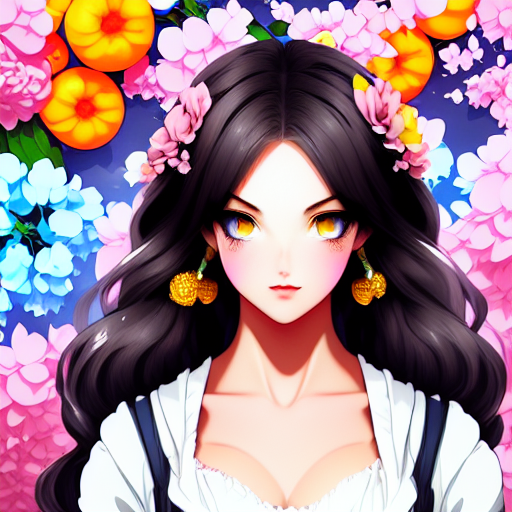

In [17]:
# Optional: Test the Dreambooth model
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch

output_dir = "output"

preview_prompt = f"sks, a illustration of girl. walking in supermarket, 8k, lineart, extremly detailed eyes, digital painting. masterpiece, best quality."
negative_prompt = "grain, pattern, disfigured, kitsch, ugly, oversaturated, grain, low-res, Deformed, blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, extra limb, poorly drawn hands, missing limb, blurry, floating limbs, disconnected limbs, malformed hands, blur, out of focus, long neck, long body, disgusting, poorly drawn, childish, mutilated, mangled, old, surreal"

if pipeline is None:
  pipeline = StableDiffusionPipeline.from_pretrained(
      "stable-diffusion-v1-5/stable-diffusion-v1-5",
      torch_dtype=torch.float16,
  ).to("cuda")

pipeline.enable_xformers_memory_efficient_attention()

pipeline.load_lora_weights(output_dir, weight_name="pytorch_lora_weights.safetensors")

scheduler_args = {}

if "variance_type" in pipeline.scheduler.config:
    variance_type = pipeline.scheduler.config.variance_type

    if variance_type in ["learned", "learned_range"]:
        variance_type = "fixed_small"

    scheduler_args["variance_type"] = variance_type

pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config, **scheduler_args)

output = pipeline(
    preview_prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7,
)

display(output.images[0])

In [ ]:
# 4. Download your model.savetensors
# If you are using Colab, you can mount Google Drive and upload your model.safetensors
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # Create a directory in Google Drive if it doesn't exist
    import os
    target_dir = "/content/drive/MyDrive/Dreambooth"
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        print(f"Created directory: {target_dir}")
    else:
        print(f"Directory already exists: {target_dir}")

    # Copy your file to Drive
    !cp /content/model.safetensors {target_dir}/{token_name}.safetensors
    print(f"Your Dreambooth model has been uploaded to your Google Drive folder {target_dir}")
except:
  pass